In [2]:
import pandas as pd
import numpy as np
import arviz as az
import pymc as pm

# 1.

df = pd.read_csv("bike_daily.csv")

temps  = df["temp_c"].values
rentals = df["rentals"].values
humiditys = df["humidity"].values
winds = df["wind_kph"].values
is_holidays = df["is_holiday"].values
seasons = df["season"].values

percentile_75 = np.percentile(rentals, 75)
print("Percentile 75 of rentals: ", percentile_75)

df.head()
df.describe()

Percentile 75 of rentals:  708.0


,rentals,temp_c,humidity,wind_kph,is_holiday
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,642.224000,15.489139,0.596956,12.306182,0.486000
std,97.604873,7.600945,0.205447,4.908556,0.500305
min,326.000000,-2.869506,0.100000,0.500000,0.000000
25%,586.750000,10.113000,0.452484,8.972031,0.000000
50%,650.500000,15.458780,0.610855,12.695856,0.000000
75%,708.000000,21.008264,0.762037,15.640269,1.000000
max,877.000000,32.641380,0.950000,28.036704,1.000000


array([[<Axes: xlabel='temp_c', ylabel='temp_c'>,
        <Axes: xlabel='humidity', ylabel='temp_c'>,
        <Axes: xlabel='wind_kph', ylabel='temp_c'>,
        <Axes: xlabel='rentals', ylabel='temp_c'>],
       [<Axes: xlabel='temp_c', ylabel='humidity'>,
        <Axes: xlabel='humidity', ylabel='humidity'>,
        <Axes: xlabel='wind_kph', ylabel='humidity'>,
        <Axes: xlabel='rentals', ylabel='humidity'>],
       [<Axes: xlabel='temp_c', ylabel='wind_kph'>,
        <Axes: xlabel='humidity', ylabel='wind_kph'>,
        <Axes: xlabel='wind_kph', ylabel='wind_kph'>,
        <Axes: xlabel='rentals', ylabel='wind_kph'>],
       [<Axes: xlabel='temp_c', ylabel='rentals'>,
        <Axes: xlabel='humidity', ylabel='rentals'>,
        <Axes: xlabel='wind_kph', ylabel='rentals'>,
        <Axes: xlabel='rentals', ylabel='rentals'>]], dtype=object)

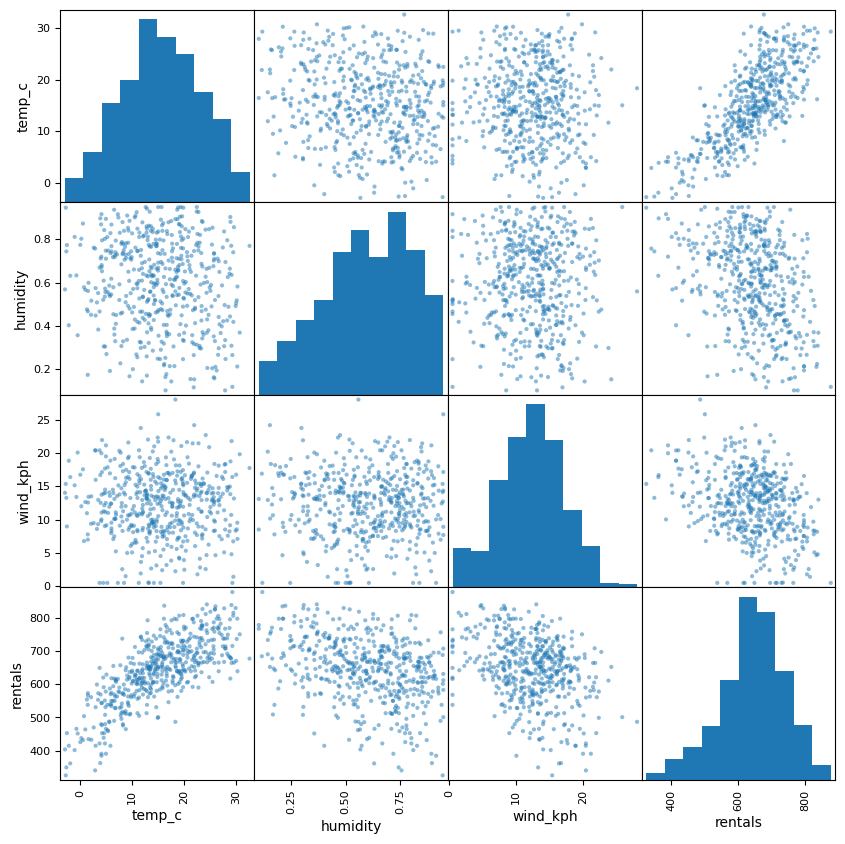

In [ ]:

pd.plotting.scatter_matrix(df[["temp_c", "humidity", "wind_kph", "rentals"]], figsize=(10, 10))


# Putem vedea ca exista liniaritate acolo unde datele urmeaza un parcurs relativ "liniar"
# si intuitiv, punctele sunt mai apropiate ( ex: temp_c -- rentals)

# Pe de alta parte, unde punctele sunt foarte imprastiate inseamna ca avem un coeficient de liniaritate
# salb (ex: wind_kph - humidity)

In [4]:
# 2.

# a)
attrs = [temps, humiditys, winds] 

for attr in attrs:
    attr_mean = attr.mean(axis=0)
    attr_std = attr.std(axis=0)
    attr = (attr - attr_mean) / attr_std

rentals_mean = rentals.mean(axis=0)
rentals_std = rentals.std(axis=0)
rentals = (rentals - rentals_mean) / rentals_std


In [ ]:


# a) (1p) Using weakly informative prior distributions for the parameters α, β1, β2 and σ, use PyMC to simulate a
# sufficiently large sample from the posterior distribution.

with pm.Model() as bayesian_linear_model:
    alpha = pm.Normal("alpha", mu=0, sigma=1000)
    beta1 = pm.Normal("beta1", mu=0, sigma=100)
    beta2 = pm.Normal("beta2", mu=0, sigma=100)
    beta3 = pm.Normal("beta3", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=1000)

    
    mu = alpha + beta1 * temps + beta2 * humiditys + beta3 * winds

    rentals_distrib = pm.Normal("price", mu=mu, sigma=sigma, observed=rentals)

    
    idata_linear = pm.sample(
        draws=2000,       
        tune=2000,       
        target_accept=0.9,
        chains=4,
        cores=4,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )


with pm.Model() as bayesian_polynomial_model:
    alpha = pm.Normal("alpha", mu=0, sigma=1000)
    beta1 = pm.Normal("beta1", mu=0, sigma=100)
    beta2 = pm.Normal("beta2", mu=0, sigma=100)
    beta3 = pm.Normal("beta3", mu=0, sigma=100)
    beta4 = pm.Normal("beta4", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=1000)

    
    mu = alpha + beta1 * (temps) + beta2 * humiditys + beta3 * winds + beta4 * (temps ** 2) # extra term

    
    rentals_distrib = pm.Normal("rentals", mu=mu, sigma=sigma, observed=rentals)

    
    idata_polynomial = pm.sample(
        draws=2000,       
        tune=2000,       
        target_accept=0.9,
        chains=4,
        cores=4,
        return_inferencedata=True,
        idata_kwargs={"log_likelihood": True}
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta1, beta2, beta3, beta4, sigma]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 7 seconds.


In [6]:
# Linear model

# beta1 -> temperatura
# beta2 -> humidity
# beta3 -> wind

az.summary(idata_linear, var_names=["beta1", "beta2", "beta3"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,0.093,0.003,0.087,0.099,0.000,0.000,4901.0,5050.0,1.0
beta2,-1.241,0.112,-1.463,-1.030,0.002,0.001,3606.0,4542.0,1.0
beta3,-0.068,0.005,-0.077,-0.059,0.000,0.000,5244.0,4890.0,1.0


In [ ]:
# Polynomial model

# beta1 -> temperatura
# beta2 -> humidity
# beta3 -> wind

# cel mai mult influenteaza datele umiditatea, am putea spune ca pt o "unitate"
# de umiditate inchirierile scad in medie cu 121 (-1.270 standardizat), iar intervalul hdi
# este [-1.505, -1.092] ( mare fata de celelalte atribute )

# Am facut si calculele nestandardizate
# si am obtinut urm rezultate (similare pt ambele modele):

#         mean    |  sd
# beta1  0.253     0.0011
# beta2  -121.9    13.157
# beta3  -6.84     0.542


az.summary(idata_polynomial, var_names=["beta1", "beta2", "beta3", "beta4"], hdi_prob=0.95)


# In plus putem observa ca termenul extra (temp_c ^ 2) nu aduce prea multe informatii despre 
# rentals, are deviatia std = 0 si intervalul high denisty [-0.004, -0.002] 
# dar face modelul polinomial mai robust
# (posibil overfitting)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta1,0.183,0.010,0.164,0.204,0.000,0.000,3443.0,3816.0,1.0
beta2,-1.296,0.106,-1.505,-1.092,0.001,0.001,5338.0,5370.0,1.0
beta3,-0.066,0.004,-0.074,-0.057,0.000,0.000,5537.0,5129.0,1.0
beta4,-0.003,0.000,-0.004,-0.002,0.000,0.000,3509.0,3912.0,1.0


In [8]:
idata_dict = {
    "linear": idata_linear,
    "polynomial": idata_polynomial
}


In [9]:
waic_cmp = az.compare(idata_dict, ic="waic")
waic_cmp


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
polynomial,0,-341.477379,5.691731,0.000000,1.000000e+00,15.605388,0.000000,False,log
linear,1,-381.402117,5.098893,39.924738,7.112533e-12,16.340199,7.763644,False,log


In [ ]:
loo_cmp = az.compare(idata_dict, ic="loo")
loo_cmp


# Ambele criterii de comparatie (WAIC si LOO) au rezultat ca modelul polinomial este mai bun decat cel liniar.
# Totusi LOO e mai ok pt date in care avem outliers
# Avand in vedere ca datele despre inchirieri de biciclete pot avea variatii semnificative   


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
polynomial,0,-341.483721,5.698073,0.000000,1.000000e+00,15.605876,0.000000,False,log
linear,1,-381.407618,5.104395,39.923897,1.934808e-11,16.340795,7.763885,False,log


<Axes: title={'center': 'beta1'}>

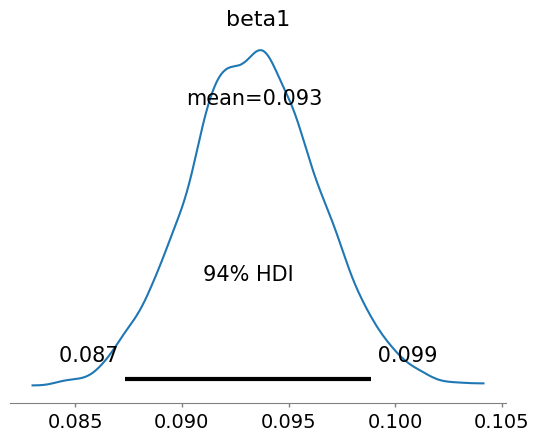

In [11]:
az.plot_posterior(idata_linear, var_names=["beta1"])

<Axes: title={'center': 'beta1'}>

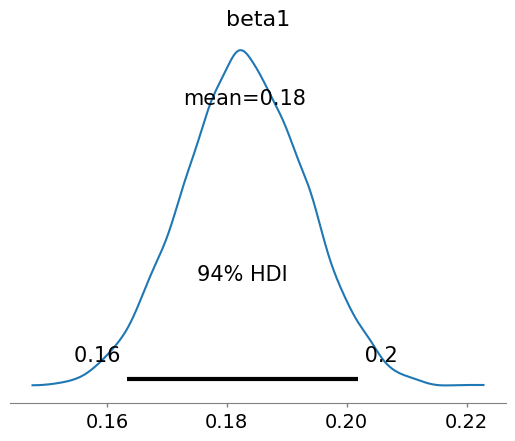

In [12]:
az.plot_posterior(idata_polynomial, var_names=["beta1"])

In [ ]:
attr = df[["temp_c", "humidity", "wind_kph"]].values
# Am ales sa elimin (temp_c^2) deoarece nu aduce beneficiu in acest caz ( am justificat mai sus la ex 2)

rentals = df[["rentals"]].values

with pm.Model() as model:

    alpha = pm.Normal("alpha", mu=0, sigma=5)
    beta = pm.Normal("beta", mu=0, sigma=5, shape=3)

    is_high_demand = (df["rentals"].values > percentile_75).astype(int)

    mu = alpha + pm.math.dot(attr, beta)

    p = pm.Deterministic("p", pm.math.sigmoid(mu))
    y_obs = pm.Bernoulli("y_obs", p=p, observed=is_high_demand)

    # Sampling
    trace = pm.sample(
        2000,
        tune=2000,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


Output()

Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [14]:

az.summary(trace, var_names=["alpha", "beta"], hdi_prob=0.95)

# beta1 -> temperatura
# beta2 -> humidity
# beta3 -> wind


# se poate observa ca umiditatea influenteaza in acest caz high_demandul
# in zilele cu umiditate mare -> no high_demand
# mean(humidity) = -4.606 si intre [-5.99, -3.104] ca interval


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.312,0.595,-0.798,1.554,0.014,0.010,1779.0,2157.0,1.0
beta[0],0.231,0.025,0.183,0.280,0.001,0.000,2029.0,1795.0,1.0
beta[1],-4.650,0.724,-6.142,-3.326,0.017,0.012,1833.0,1888.0,1.0
beta[2],-0.259,0.033,-0.324,-0.196,0.001,0.001,2021.0,2116.0,1.0
